In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import os
from datetime import datetime
import seaborn as sns
from fred import Fred

## Step 1: Request data

In [2]:
def observations(identifier, **kwargs):
    """Get an economic data series."""
    kwargs['series_id'] = identifier
    return Fred().series('observations', **kwargs)

os.environ['FRED_API_KEY'] = 'd5fe08647bfe87ba6e9eda58259d032a'
data = []
for series in ['GS1','GS2','GS3','GS5','GS7','GS10']:
    data_request = observations(series)['observations']
    df = pd.DataFrame(data_request)[['date','value']]
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    data.append(df)
dfdata = pd.concat(data, axis=1).loc[datetime(1976,6,1):,:].astype(np.float32)
dfdata.columns = ['GS1','GS2','GS3','GS5','GS7','GS10']
dfdata.head()

,GS1,GS2,GS3,GS5,GS7,GS10
date,,,,,,
1976-06-01,6.52,7.06,7.31,7.61,7.75,7.86
1976-07-01,6.20,6.85,7.12,7.49,7.70,7.83
1976-08-01,6.00,6.63,6.86,7.31,7.58,7.77
1976-09-01,5.84,6.42,6.66,7.13,7.41,7.59
1976-10-01,5.50,5.98,6.24,6.75,7.16,7.41


In [3]:
dfdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 1976-06-01 to 2021-09-01
Freq: MS
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GS1     544 non-null    float32
 1   GS2     544 non-null    float32
 2   GS3     544 non-null    float32
 3   GS5     544 non-null    float32
 4   GS7     544 non-null    float32
 5   GS10    544 non-null    float32
dtypes: float32(6)
memory usage: 17.0 KB


### Data transformation

In [4]:
def month_chg(data): 
    """
    Calculate monthly changes of data
    """
    return np.log(data/data.shift(1)).dropna()

def normalize(data):
    """
    Data Normalization to unite scale and distribution
    """
    return (data - np.mean(data,axis=0))/np.std(data, axis=0)

In [5]:
# check N/A values
if dfdata.isnull().values.sum() != 0:
    dfdata = dfdata.fillna(method='ffill')
data_chg = month_chg(dfdata)
data_norm = normalize(data_chg)
data_norm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543 entries, 1976-07-01 to 2021-09-01
Freq: MS
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GS1     543 non-null    float32
 1   GS2     543 non-null    float32
 2   GS3     543 non-null    float32
 3   GS5     543 non-null    float32
 4   GS7     543 non-null    float32
 5   GS10    543 non-null    float32
dtypes: float32(6)
memory usage: 17.0 KB


## Step 2: Dimension reduction - PCA

In [6]:
# PCA transformation
ncol = data_norm.shape[1]
pca1 = PCA(n_components = 'mle')
data_pca_mle = pca1.fit_transform(data_norm.values)
print (pca1.explained_variance_ratio_)

pca2 = PCA(n_components = 0.99)
data_pca = pca2.fit_transform(data_norm.values)
print (pca2.explained_variance_ratio_)

[0.8812351  0.0857701  0.02680851 0.00421766 0.00123826]
[0.8812351  0.0857701  0.02680851]


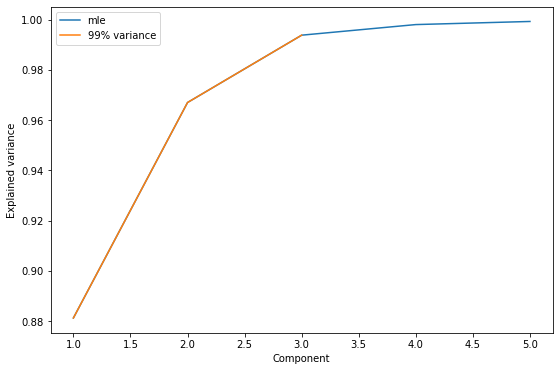

In [7]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(1,len(pca1.explained_variance_ratio_) + 1),np.cumsum(pca1.explained_variance_ratio_),label='mle')
plt.plot(np.arange(1,len(pca2.explained_variance_ratio_) + 1),np.cumsum(pca2.explained_variance_ratio_),label='99% variance')
plt.xlabel('Component')
plt.ylabel('Explained variance')
plt.legend()

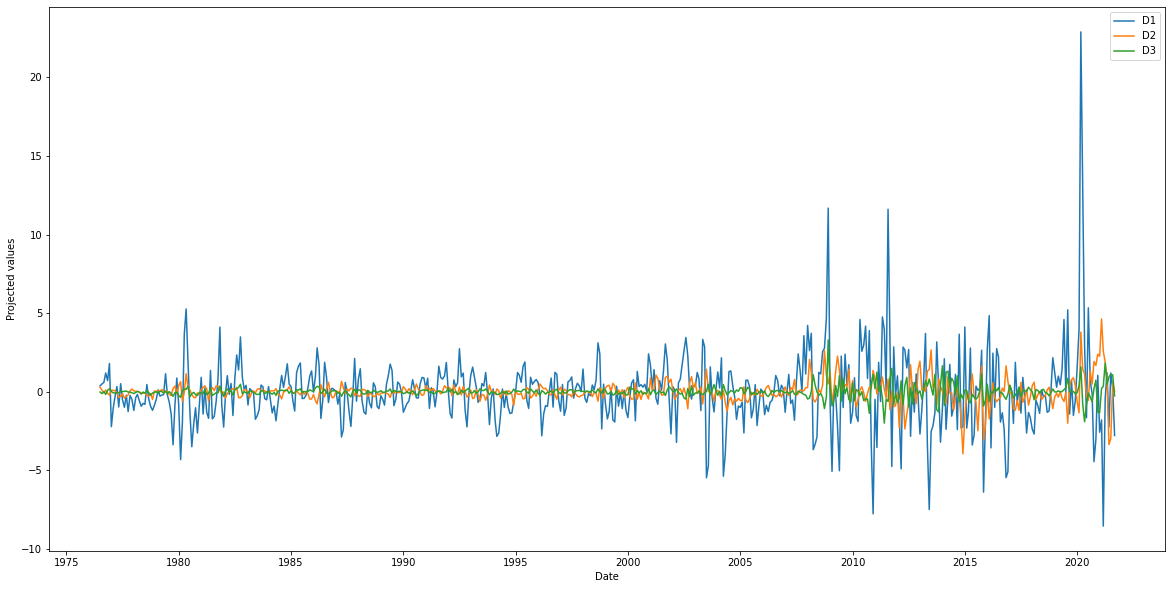

In [8]:
# data_pca_mle = pd.DataFrame(data_pca_mle, columns = ['D1','D2','D3','D4','D5'])
data_pca = pd.DataFrame(data_pca, columns = ['D1','D2','D3'], index=data_norm.index)
x = data_norm.index.tolist()
fig = plt.figure(figsize=(20,10))
for col in data_pca.columns:
    plt.plot(x, data_pca[col],label=col)
plt.xlabel('Date')
plt.ylabel('Projected values')
plt.legend()

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


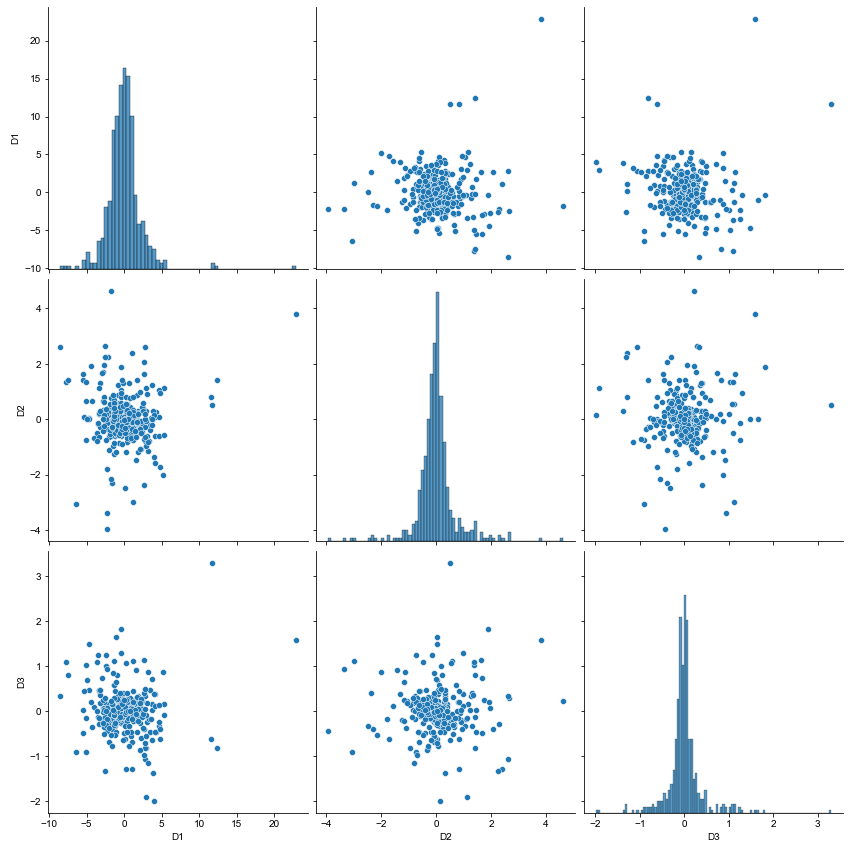

In [9]:
_ = sns.pairplot(data_pca, size=4)
sns.set_theme()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
print("Whole period: ")
for col in data_pca.columns:
    result = adfuller(data_pca.loc[:,col]) 
    print("%s adf value: " % col, result[0])
    print("%s p-value: " % col, result[1]) # reject null hypothesis if p-value < 0.05
    
print("2010 - Current ")
for col in data_pca.columns:
    result = adfuller(data_pca.loc[datetime(2010,1,1):,col]) 
    print("%s adf value: " % col, result[0])
    print("%s p-value: " % col, result[1]) # reject null hypothesis if p-value < 0.05

print("2020 - Current ")
for col in data_pca.columns:
    result = adfuller(data_pca.loc[datetime(2020,1,1):,col]) 
    print("%s adf value: " % col, result[0])
    print("%s p-value: " % col, result[1]) # reject null hypothesis if p-value < 0.05
    
# Conclusion: 
# 1. In the long-term, reduced data are stationary.
# 2. From 2010, p-value increases for D3, showing that there is weaker evidence to reject null hypothesis(non-stationarity)
# 3. From 2020, we accept the null hypotheses at 90% confidence level and reduced data is extremely instable. 

Whole period: 
D1 adf value:  -4.965817927029905
D1 p-value:  2.5922707060301882e-05
D2 adf value:  -7.542072010782955
D2 p-value:  3.3575919460518044e-11
D3 adf value:  -7.258019215684662
D3 p-value:  1.710477452279478e-10
2010 - Current 
D1 adf value:  -8.686037510786939
D1 p-value:  4.160979898316991e-14
D2 adf value:  -7.612795684794924
D2 p-value:  2.2320421743408007e-11
D3 adf value:  -4.1271032082655195
D3 p-value:  0.000873299863467853
2020 - Current 
D1 adf value:  -2.455849143220965
D1 p-value:  0.1265894799039492
D2 adf value:  -2.300341079105866
D2 p-value:  0.17185799031391247
D3 adf value:  2.734411235872013
D3 p-value:  0.9990880582168882


## Step 3: Detect the most similar year

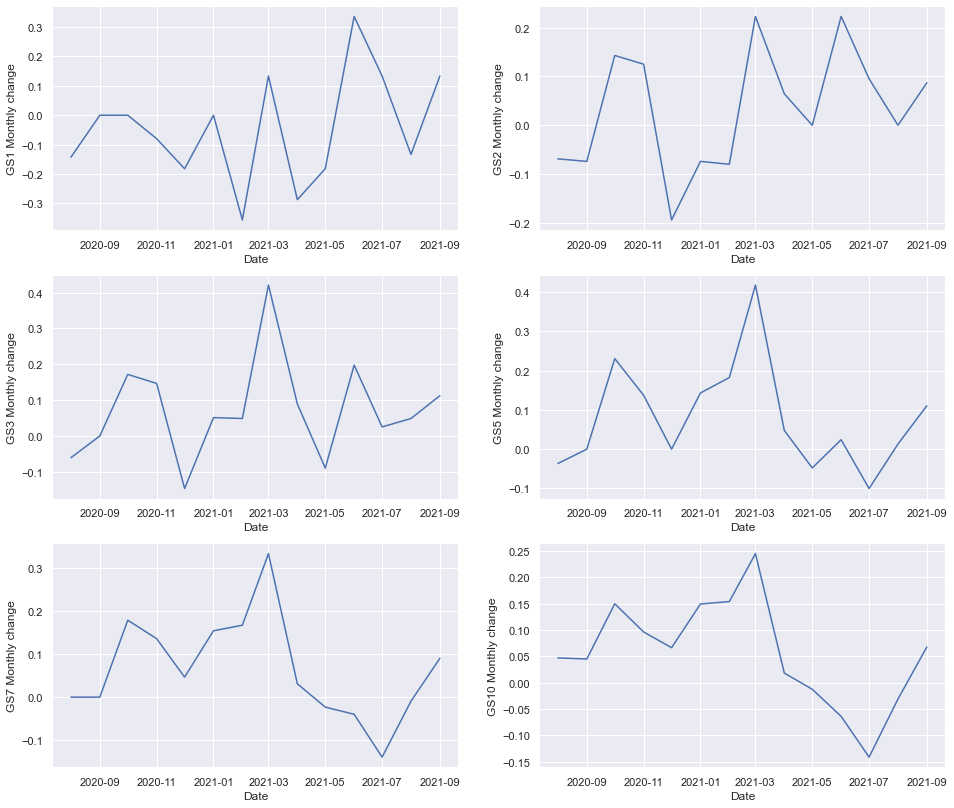

In [11]:
columns = data_chg.columns
fig = plt.figure(figsize=(16,14))
for i in range(6):
    ax1 = plt.subplot(3,2,i+1)
    plt.plot(data_chg.loc[datetime(2020,8,1):,columns[i]])
    plt.xlabel('Date')
    plt.ylabel('%s Monthly change' % columns[i])

### DTW Model

In [12]:
def SeriesSimilarity(s1, s2):
    l1 = len(s1)
    l2 = len(s2)
    cum_paths = np.full((l1 + 1, l2 + 1), np.inf)  # 全部赋予无穷大
    cum_paths[0, 0] = 0
    for i in range(l1):
        for j in range(l2):
            cost = (s1[i] - s2[j]) ** 2
            cum_paths[i + 1, j + 1] = cost + min(cum_paths[i, j + 1], cum_paths[i + 1, j], cum_paths[i, j])

    paths = np.sqrt(cum_paths)
    dist = paths[l1, l2]
    return dist, paths.T


In [13]:
targets = data_norm.loc[datetime(2020,9,1):datetime(2021,8,1)]
series = targets.columns.tolist()
all_dists = []
for year in range(1976,2020):
    partition = data_norm[data_chg.index.year == year]
    s_dists = []
    for s in series:
        target = targets[s]
        part_s = partition[s]
        d, path = SeriesSimilarity(part_s, target)
        s_dists.append(d)
    all_dists.append(s_dists)

df_dists = pd.DataFrame(all_dists, index=[y for y in range(1976,2020)], columns = series)
   

In [14]:
df_dists

,GS1,GS2,GS3,GS5,GS7,GS10
1976,5.112045,4.395026,5.827061,6.755055,6.607512,6.293662
1977,5.241338,3.504269,4.601170,4.829560,4.558797,4.957434
1978,5.264911,3.613588,4.652511,5.515357,5.624625,5.335314
1979,4.860642,3.287287,4.325355,4.167226,3.814946,3.984595
1980,4.412108,2.055709,3.403731,4.299172,4.024739,3.902092
1981,4.489371,3.493483,4.306360,5.152380,4.815284,4.577560
1982,4.451321,3.861867,4.757012,4.923891,4.556267,4.057023
1983,5.143926,3.256813,4.630542,5.114895,5.194037,5.194186
1984,5.046359,3.719397,4.860353,5.042856,4.789148,4.324184
1985,5.020892,3.418983,4.851782,5.606398,5.523522,5.278821


In [15]:
sum_dist = df_dists.sum(axis=1).sort_values()
sum_dist.head()

2009    21.499666
1980    22.097551
2013    22.513271
2004    22.899916
1987    23.803237
dtype: float64

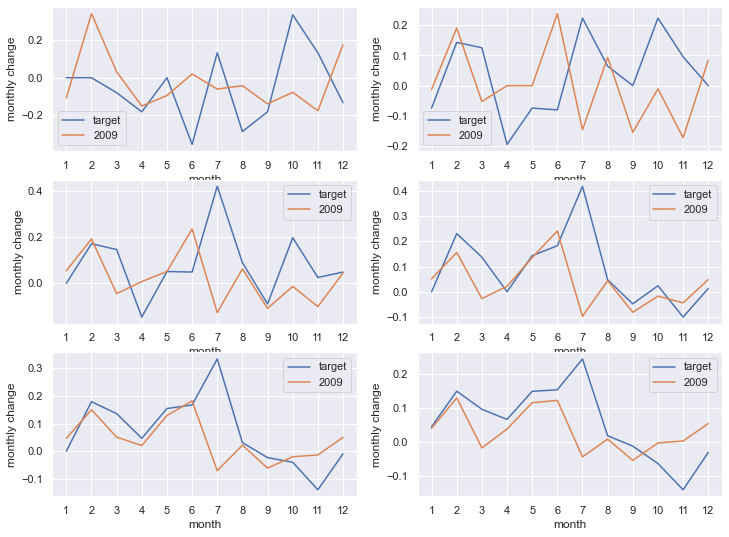

In [16]:
# plot original monthly change data series
targets = data_chg.loc[datetime(2020,9,1):datetime(2021,8,1)]
fig = plt.figure(figsize=(12,9))
for s in range(len(series)):
    plt.subplot(3,2,s+1)
    plt.plot(targets[series[s]].values,label = 'target')
    plt.plot(data_chg[data_chg.index.year == sum_dist.index[0]][series[s]].values, label=str(sum_dist.index[0]))
    plt.xticks([x for x in range(12)],[x for x in range(1,13)])
    plt.xlabel('month')
    plt.ylabel('monthly change')
    plt.legend()


### DTW Improved model

In [17]:
def SeriesSimilarityImprove(s1, s2):
    sdt = np.std(s1, ddof=1) if np.std(s1, ddof=1) > np.std(s2, ddof=1) else np.std(s2, ddof=1)
    l1 = len(s1)
    l2 = len(s2)
    cum_paths = np.full((l1 + 1, l2 + 1), np.inf) 
    cum_paths[0, 0] = 0
    sub_matrix = np.full((l1, l2), 0) 
    max_sub_len = 0
    
    for i in range(l1):
        for j in range(l2):
            cost = (s1[i] - s2[j]) ** 2
            cum_paths[i + 1, j + 1] = cost + min(cum_paths[i, j + 1], cum_paths[i + 1, j], cum_paths[i, j])
            if np.abs(s1[i] - s2[j]) < sdt:
                if i == 0 or j == 0:
                    sub_matrix[i][j] = 1
                else:
                    sub_matrix[i][j] = sub_matrix[i - 1][j - 1] + 1
                    max_sub_len = sub_matrix[i][j] if sub_matrix[i][j] > max_sub_len else max_sub_len

    paths = np.sqrt(cum_paths)
    dist = paths[l1, l2]
    return dist, paths.T, max_sub_len

def calculate_attenuate_weight(seqLen1, seqLen2, comlen):
    weight = (comlen / seqLen1) * (comlen / seqLen2)
    return 1 - weight
 

targets = data_norm.loc[datetime(2020,9,1):datetime(2021,8,1)]
series = targets.columns.tolist()
all_dists = []
for year in range(1976,2020):
    partition = data_norm[data_chg.index.year == year]
    s_dists = []
    for s in series:
        target = targets[s]
        part_s = partition[s]
        d, path, max_sub = SeriesSimilarityImprove(part_s, target)
        weight = calculate_attenuate_weight(len(part_s), len(target), max_sub)
        s_dists.append(d*weight)
    all_dists.append(s_dists)

df_dists_1 = pd.DataFrame(all_dists, index=[y for y in range(1976,2020)], columns = series)
sum_dist_1 = df_dists_1.sum(axis=1).sort_values()
sum_dist_1.head()

2013    16.344489
2009    16.962735
1980    17.619073
2004    19.228158
1987    19.356988
dtype: float64

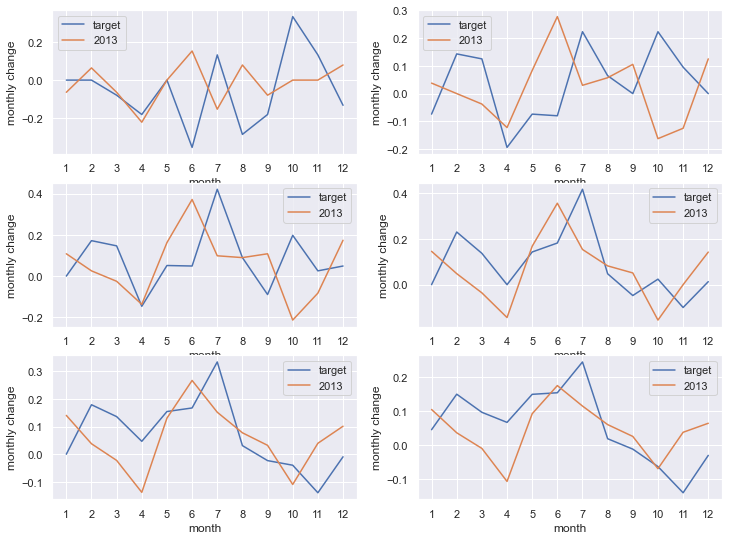

In [18]:
# plot original monthly change data series
targets = data_chg.loc[datetime(2020,9,1):datetime(2021,8,1)]
fig = plt.figure(figsize=(12,9))
for s in range(len(series)):
    plt.subplot(3,2,s+1)
    plt.plot(targets[series[s]].values,label = 'target')
    plt.plot(data_chg[data_chg.index.year == sum_dist_1.index[0]][series[s]].values, label=str(sum_dist_1.index[0]))
    plt.xticks([x for x in range(12)],[x for x in range(1,13)])
    plt.xlabel('month')
    plt.ylabel('monthly change')
    plt.legend()
